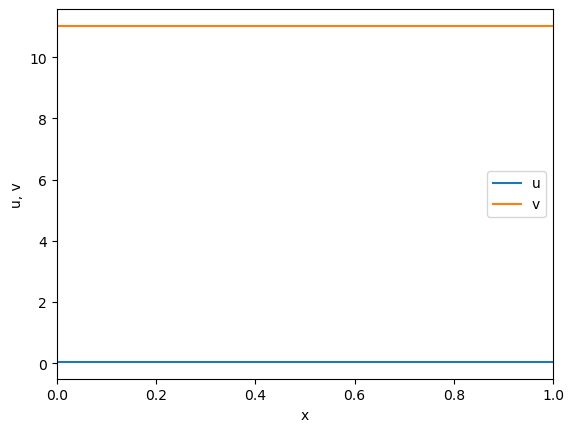

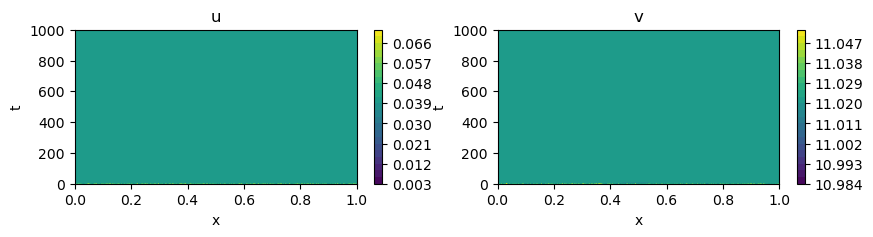

In [1]:
# This script performs a forward time-integration of the reaction-diffusion equation
# u_t = u_xx + a - u - uv^2
# v_t = d v_xx - m v + uv^2

## Packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Parameters for Reaction-Diffusion Model
a = 5
m = 0.45
d = 0.001
L = 1 # length of domain

## Options for numerics
M = 1001 # grid size
T = 1000 # end-time for the simulation
T_points = 1000 # How many equally spaced time points you want in the output

## Options for plotting
# higher level of detail will yield nicer contourplots, because Python will
# then have more slightly different color gradients to work with. However,
# this will very rapidly increase the computation power needed (for plotting)
contoutplot_level_of_detail = 25

## Initial conditions
# will be random perturbations around a uniform baseline

# baseline
ub = 2 * m**2 / (a + np.sqrt(a**2-4*m**2))
vb = 1/(2*m) * (a + np.sqrt(a**2-4*m**2))

y0 = np.empty(2*M)
u0 = ub * np.ones(M) + 0.01*np.random.normal(0,1,M) # second term is random non-uniform perturbation
v0 = vb * np.ones(M) + 0.01*np.random.normal(0,1,M) # second term is random non-uniform perturbation
y0[::2] = u0
y0[1::2]= v0



## The reaction parts of the equation
# u-equation
def ff(u,v, a, m):
    return a - u - u * v * v
# v-equation
def gg(u,v, a, m):
    return -m * v + u * v * v
    
## define the right-hand side of the ODE
h = L/(M) # distance between grid points
def discretised_pde(y,t,d, a, m):
    # obtain u and v data
    u = y[::2]
    v = y[1::2]
    
    # compute change in u and v
    dydt = np.empty_like(y)
    dudt = dydt[::2]
    dvdt = dydt[1::2]
    
    # First terms are discretisation of laplacian in 1D
    # the Neumann-BCs are used here by using 0 = u_x(0) = u(1) - u(-1) etc.
    dudt[0] = 1/h**2 * (-2*u[0]+2*u[1]) + ff(u[0],v[0],a,m)
    dudt[1:-1] = 1/h**2 * np.diff(u,2) + ff(u[1:-1],v[1:-1],a,m)
    dudt[-1] = 1/h**2 * (2*u[-2]-2*u[-1]) + ff(u[-1],v[-1],a,m)
    
    
    dvdt[0] = d/h**2 * (-2*v[0]+2*v[1]) + gg(u[0],v[0],a,m)
    dvdt[1:-1] = d/h**2 * np.diff(v,2) + gg(u[1:-1],v[1:-1],a,m)
    dvdt[-1] = d/h**2 * (2*v[-2]-2*v[-1]) + gg(u[-1],v[-1],a,m)
    
    return dydt
    

## Numerical integration
tspan = np.linspace(0,T, T_points)

# the next line solves the ode
# note that ml, mu = 2 signals to the solver that the Jacobian is a band around
# the diagonal, which is true because of the chosen boundary conditions and
# because of the chosen way to represent y as y=[u(0),v(0), u(1), ...]
ypde_sol = odeint(discretised_pde, y0, tspan, args=(d,a,m), ml=2,mu=2, mxstep=1000)

us = ypde_sol[:,::2]
vs = ypde_sol[:,1::2]
xs = np.linspace(0,L,M)



## Plotting
# Plot end state of simulation
fig, ax = plt.subplots()
ax.set_xlim([0,L])
line_u, = ax.plot(xs,us[-1,:])
line_v, = ax.plot(xs,vs[-1,:])
ax.legend([line_u,line_v], ['u', 'v'])
ax.set_xlabel('x')
ax.set_ylabel('u, v')
plt.savefig('end_state.pdf')

# Plot time evolution in contourplots
X, Y = np.meshgrid(xs,tspan)
fig2 = plt.figure(figsize=(10,2))
ax21 = fig2.add_subplot(121)
cont_plot_u = ax21.contourf(X, Y, us, contoutplot_level_of_detail)
ax21.set_xlabel('x')
ax21.set_ylabel('t')
ax21.set_title('u')
fig2.colorbar(cont_plot_u)

ax22 = fig2.add_subplot(122)
cont_plot_v = ax22.contourf(X, Y, vs, contoutplot_level_of_detail)
ax22.set_xlabel('x')
ax22.set_ylabel('t')
ax22.set_title('v')
fig2.colorbar(cont_plot_v)
plt.savefig('contourplots.pdf')

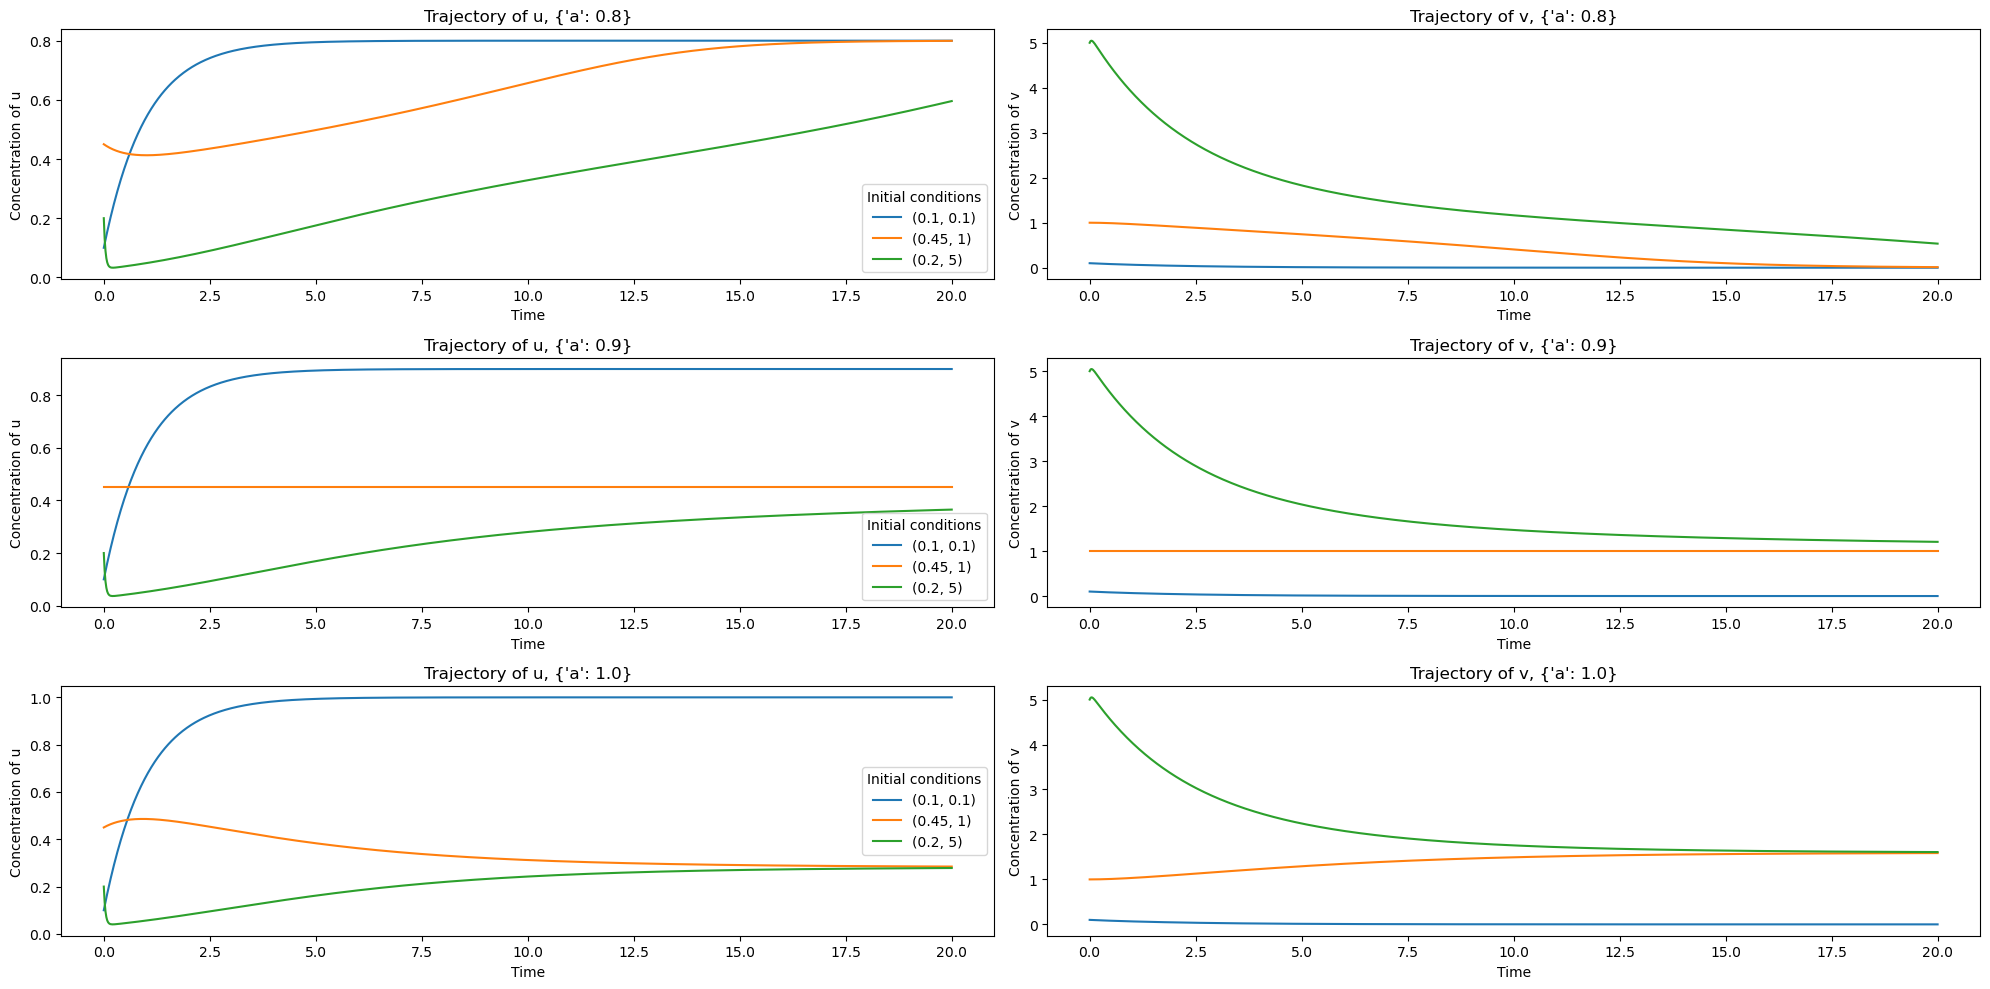

In [2]:
from scipy.optimize import fsolve
from functools import partial 
from collections import defaultdict 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.integrate 
import matplotlib.patches as mpatches 

#trajectories 
scenarios = [{'a':0.8},{'a':0.9}, {'a':1.0}]
initial_test = [(0.1,0.1),(0.45,1),(0.2,5)]
time = np.linspace(0,20,1000)
m=0.45

def homogenous_model(y,t,a,m):
    u, v = y
    return np.array([a-u-u*v*v,
                     -m*v + u*v*v])

traj = {}
for i, param in enumerate(scenarios):
    for j, ic in enumerate(initial_test):
        traj[i,j] = scipy.integrate.odeint(partial(homogenous_model,m=m, **param),
                                           y0 = ic,
                                           t = time)                                        

fig, ax = plt.subplots(3, 2, figsize=(20, 10))  # 3 rows, 2 columns
ax = ax.flatten()  

# Plot trajectories
for i, param in enumerate(scenarios):
    for j, ic in enumerate(initial_test):
        ax[2 * i].set(xlabel='Time', ylabel='Concentration of u', title='Trajectory of u, {}'.format(param))
        ax[2 * i + 1].set(xlabel='Time', ylabel='Concentration of v', title='Trajectory of v, {}'.format(param))
        
        l = ax[2 * i].plot(time, traj[i, j][:, 0], label=ic)
        ax[2 * i + 1].plot(time, traj[i, j][:, 1], color=l[0].get_color())
    
    ax[2 * i].legend(title='Initial conditions')

plt.tight_layout()
plt.show()


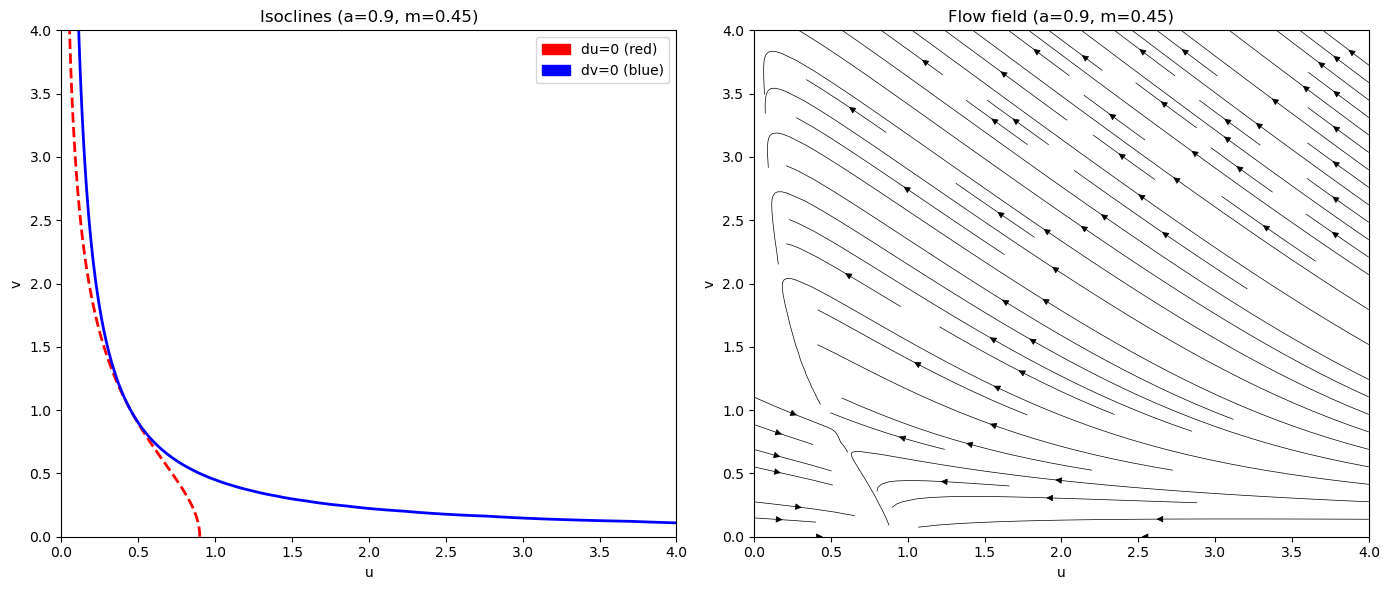

In [3]:

# Define the model
def homogenous_model_vectorized(U, V, a, m):
    du = a - U - U * V**2
    dv = -m * V + U * V**2
    return du, dv

# Isocline plot (nullclines)
def plot_isoclines(ax, uspace, vspace, a, m):
    U, V = np.meshgrid(uspace, vspace)
    du, dv = homogenous_model_vectorized(U, V, a, m)
    
    du_nullcline = ax.contour(U, V, du, levels=[0], colors='red', linestyles='--', linewidths=2)
    dv_nullcline = ax.contour(U, V, dv, levels=[0], colors='blue', linestyles='-', linewidths=2)
    
    red_patch = mpatches.Patch(color='red', label='du=0 (red)')
    blue_patch = mpatches.Patch(color='blue', label='dv=0 (blue)')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')
    
    ax.set(xlabel='u', ylabel='v', title=f"Isoclines (a={a}, m={m})")

# Phase flow plot
def plot_flow(ax, param, uspace, vspace):
    U, V = np.meshgrid(uspace, vspace)
    du, dv = homogenous_model_vectorized(U, V, param['a'], m)
    
    ax.streamplot(U, V, du, dv, color='black', density=1, linewidth=0.5)
    ax.set(xlim=(uspace.min(), uspace.max()), ylim=(vspace.min(), vspace.max()), 
           xlabel='u', ylabel='v', title=f"Flow field (a={param['a']}, m={m})")

# Create a figure for phase diagrams
uspace = np.linspace(0, 4, 100)
vspace = np.linspace(0, 4, 100)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot isoclines for a given scenario
a_value = 0.9  
plot_isoclines(ax[0], uspace, vspace, a=a_value, m=m)

# Plot flow field for a given scenario
param = {'a': a_value}
plot_flow(ax[1], param, uspace, vspace)

plt.tight_layout()
plt.show()




Parameters: {'a': 0.8}

Parameters: {'a': 0.9}

Parameters: {'a': 1.0}


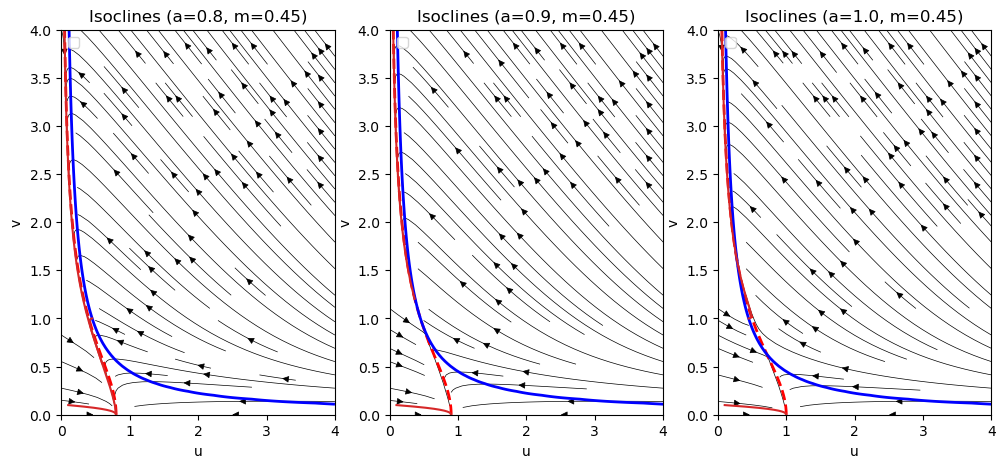

In [4]:
# stability 

def jacobian_homogenous_model(u,v,a,m):
    return np.array([[-1-v*v, -2*u*v], 
                     [v*v, -m + 2*u*v]])

def stability(jacobian):
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace,0) and np.isclose(determinant,0):
        nature = 'center (hopf)'
    elif np.isclose(determinant,0):
        nature = 'transcritical (saddle-node)'
    elif determinant < 0:
        nature = 'saddle'
    else:
        nature = 'stable' if trace <0 else 'unstable'
        nature += ' focus' if (trace**2 - 4*determinant) < 0 else ' node'
        return nature

equilibria_nature = {}
for i, param in enumerate(scenarios):
    print('\nParameters: {}'.format(param))
    equilibria_nature[i] = []
    for (u,v) in equilibria_nature[i]:
        equilibria_nature[i].append(stability(jacobian_homogenous_model(u,v, **param)))
        print('{} in ({} {})'.format( equilibria_nature[i][-1], u,v))

EQUILIBRIUM_COLOR = {'stable node' : 'C0',
                     'unstable node' : 'C1',
                     'saddle' : 'C2',
                     'stable focus' : 'C3',
                     'unstable focus' : 'C4',
                     'center (hopf)' : 'C5',
                     'transcritical (saddle-node)' : 'C6'}

def plot_equilibrium(ax, position, nature, legend = True):
    for pos, nat in zip(position,nature):
        ax.scatter(pos[0],pos[1],
                   color= (EQUILIBRIUM_COLOR[nat] 
                           if nat in EQUILIBRIUM_COLOR
                           else 'k'),
                   zorder=100)
        
    if legend:
        labels = list(frozenset(nature))
        ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels)

fig, ax = plt.subplots(1,3, figsize=(12,5))
for i, param in enumerate(scenarios):
    ax[i].set(xlabel='u', ylabel='v', title="Phase space, {}".format(param))
    plot_flow(ax[i], param, uspace=uspace, vspace=vspace)
    plot_isoclines(ax[i], uspace=uspace, vspace=vspace, **param, m=m)
    for j in range(len(initial_test)):
        ax[i].plot(traj[i,j][:,0],traj[i,j][:,1], color='C3')
    plot_equilibrium(ax[i], equilibria_nature[i], equilibria_nature[i])




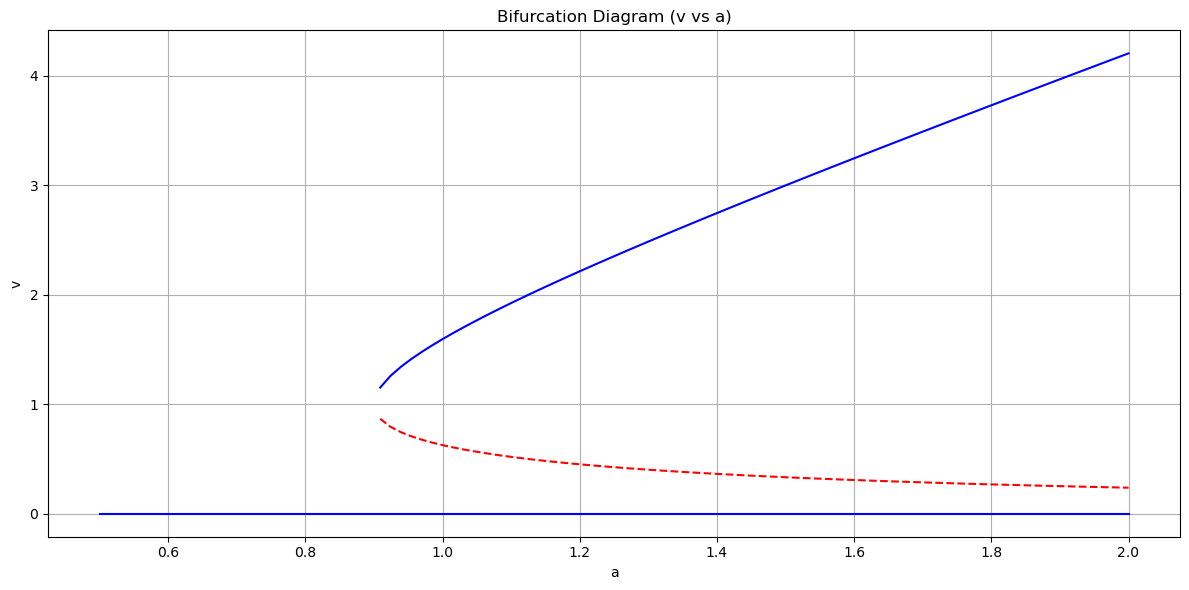

In [5]:
# # Bifurcation Diagram 

a_space = np.linspace(0.5, 2, 100)

# Function to compute v from the quadratic equation
def equilibrium_v(a, m):
    discriminant = a**2 - 4 * m**2
    if discriminant < 0:
        return [0], [] 
    v1 = (a + np.sqrt(discriminant)) / (2 * m)  
    v2 = (a - np.sqrt(discriminant)) / (2 * m)  
    return v1, v2

# Collecting branches for the bifurcation diagram
v_upper_vals_stable = []
v_lower_vals_unstable = []
critical_branch_v = []
stable_a = []
unstable_a = []

for a in a_space:
    v1, v2 = equilibrium_v(a, m)
    
    critical_branch_v.append(0)
    stable_a.append(a)

    if a >= 2 * m:  
        v_upper_vals_stable.append(v1)
        v_lower_vals_unstable.append(v2)
        unstable_a.append(a)

# Plotting the bifurcation diagram
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(unstable_a, v_upper_vals_stable, 'b')
ax.plot(unstable_a, v_lower_vals_unstable, 'r--')
ax.plot(stable_a, critical_branch_v, 'b')

ax.set(xlabel='a', ylabel='v', title='Bifurcation Diagram (v vs a)')
plt.tight_layout()
plt.grid(True)
plt.show()



In [6]:
from sympy import *

v, u, lambda_k, m, l, k, d = symbols('v u lambda_k m l k d')
P, Q, S = symbols('P Q S')


C = (pi**2 * k**2) / l**2
Peq = pi**4*d**2*k**4 - 2*pi**4*d*k**4 + 2*pi**2*d*k**2*l**2*m - 4*pi**2*d*k**2*l**2*u*v - 2*pi**2*d*k**2*l**2*v**2 - 2*pi**2*d*k**2*l**2 + pi**4*k**4 - 2*pi**2*k**2*l**2*m + 4*pi**2*k**2*l**2*u*v + 2*pi**2*k**2*l**2*v**2 + 2*pi**2*k**2*l**2 + l**4*m**2 - 4*l**4*m*u*v - 2*l**4*m*v**2 - 2*l**4*m + 4*l**4*u**2*v**2 - 4*l**4*u*v**3 + 4*l**4*u*v + l**4*v**4 + 2*l**4*v**2 + l**4
Qeq = (-pi**2*d*k**2 - pi**2*k**2 - l**2*m + 2*l**2*u*v - l**2*v**2 - l**2)
Seq = pi**2*d*k**2 + l**2*m - 2*l**2*u*v

A = Matrix([[-1 - v**2 - C, -2 * u * v], 
            [v**2, 2 * u * v - m - d*C]])

eigenvectors = A.eigenvects()

eigenvectors_substituted = [
    (key.subs({Peq: P, Qeq: Q, Seq: S}), multiplicity, [vec.subs({Peq: P, Qeq: Q, Seq: S}) for vec in vectors])
    for key, multiplicity, vectors in eigenvectors
]

print('Eigenvectors:')
for key, multiplicity, vectors in eigenvectors_substituted:
    print(f'Eigenvalue: {key}, Multiplicity: {multiplicity}, Eigenvectors: {vectors}')


determinant = A.det()
trace = A.trace()

print(f' The determinant is :{determinant}, \nThe trace is :{trace}')

Eigenvectors:
Eigenvalue: -sqrt(P)/(2*l**2) + Q/(2*l**2), Multiplicity: 1, Eigenvectors: [Matrix([
[S/(l**2*v**2) + (-sqrt(P)/(2*l**2) + Q/(2*l**2))/v**2],
[                                                    1]])]
Eigenvalue: sqrt(P)/(2*l**2) + Q/(2*l**2), Multiplicity: 1, Eigenvectors: [Matrix([
[S/(l**2*v**2) + (sqrt(P)/(2*l**2) + Q/(2*l**2))/v**2],
[                                                   1]])]
 The determinant is :(pi**4*d*k**4 + pi**2*d*k**2*l**2*v**2 + pi**2*d*k**2*l**2 + pi**2*k**2*l**2*m - 2*pi**2*k**2*l**2*u*v + l**4*m*v**2 + l**4*m - 2*l**4*u*v)/l**4, 
The trace is :-pi**2*d*k**2/l**2 - pi**2*k**2/l**2 - m + 2*u*v - v**2 - 1


For k = 1, the upper branch changes from stable to unstable at a = 0.9091
For k = 2, the upper branch changes from stable to unstable at a = 0.9091
For k = 3, the upper branch changes from stable to unstable at a = 0.9091


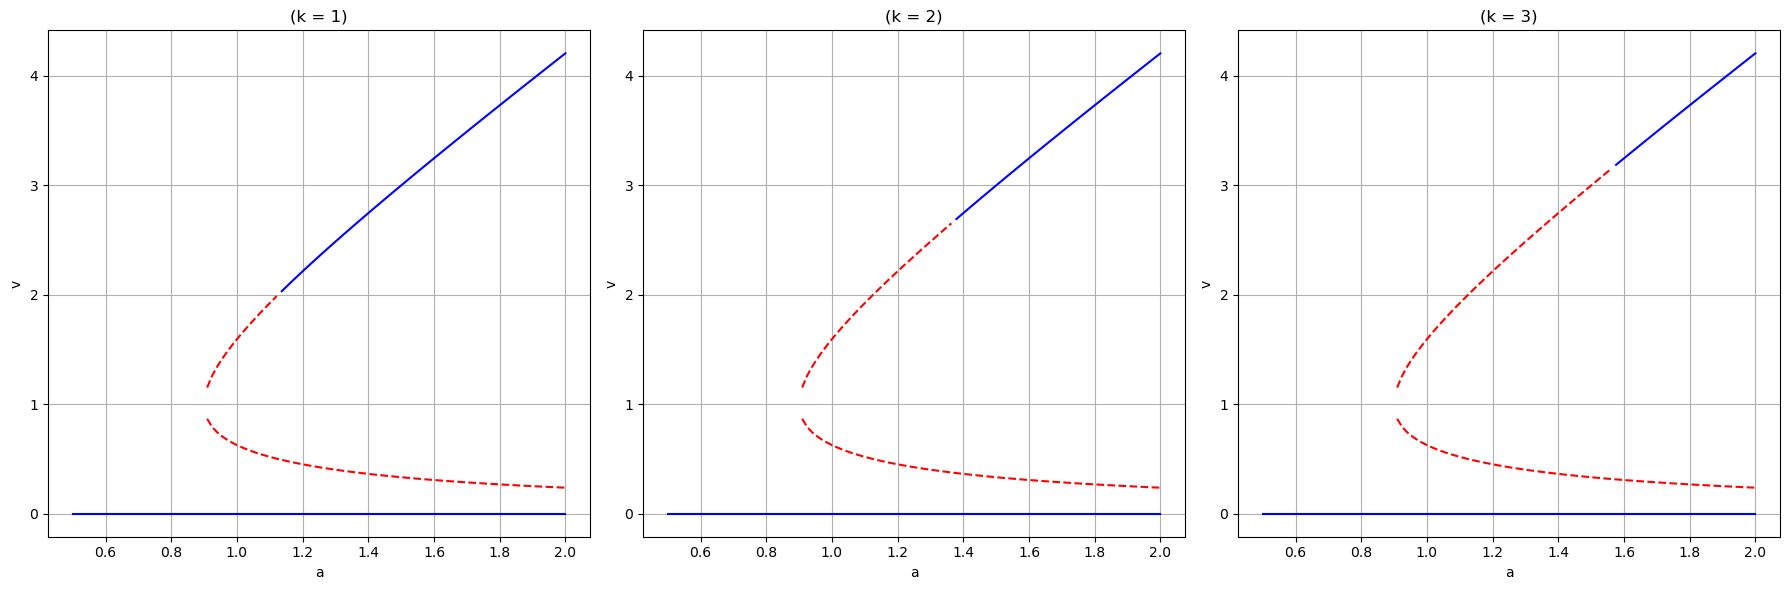

In [7]:

m = 0.45
l = 1
d = 0.001
a_space = np.linspace(0.5, 2, 100)
k_values = [1, 2, 3]

def equilibrium_v(a, m):
    discriminant = a**2 - 4 * m**2
    if discriminant < 0:
        return None, None 
    v1 = (a + np.sqrt(discriminant)) / (2 * m)  
    v2 = (a - np.sqrt(discriminant)) / (2 * m)  
    return v1, v2

def determinant(v, d, m, k):
    return d * (np.pi * k)**2 + np.pi * k * (d * (1 + v**2) - m) + m * (v**2 - 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, k in enumerate(k_values):
    
    v_upper_stable = []
    v_upper_unstable = []
    v_lower_unstable = []
    critical_branch_v = []
    stable_a = []
    unstable_a = []
    both_unstable_a = []
    lower_unstable_a = []
    stable_to_unstable_a = None

    for a in a_space:
        v1, v2 = equilibrium_v(a, m)
        
        critical_branch_v.append(0)
        stable_a.append(a)

        if v1 is not None and v2 is not None:
            det_v1 = determinant(v1, d, m, k)
            
            if det_v1 > 0:
                v_upper_stable.append(v1)
                unstable_a.append(a)
            else:
                v_upper_unstable.append(v1)
                both_unstable_a.append(a)
        
                if stable_to_unstable_a is None:
                    stable_to_unstable_a = a
            
            v_lower_unstable.append(v2)
            lower_unstable_a.append(a)
    
    if stable_to_unstable_a is not None:
        print(f"For k = {k}, the upper branch changes from stable to unstable at a = {stable_to_unstable_a:.4f}")
    
    ax = axes[idx]
    ax.plot(unstable_a, v_upper_stable, 'b')
    ax.plot(lower_unstable_a, v_lower_unstable, 'r--')
    ax.plot(both_unstable_a, v_upper_unstable, 'r--')
    ax.plot(stable_a, critical_branch_v, 'b')
    ax.set(xlabel='a', ylabel='v', title=f'(k = {k})')
    ax.grid(True)

plt.tight_layout()
plt.show()
